In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Load the data
data = pd.read_csv("Mall_Customers.csv")
print(data.head())
data.columns = ["CustomerID", "Gender", "Age", "Annual Income", "Spending Scores"]
data.columns

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


Index(['CustomerID', 'Gender', 'Age', 'Annual Income', 'Spending Scores'], dtype='object')

In [29]:
# Pre-process the data
data['Gender'] = data['Gender'].map({'Male': 0 , 'Female': 1})
data.head()

,CustomerID,Gender,Age,Annual Income,Spending Scores
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [30]:
# Scale the features
scaler = StandardScaler()
features = ['Age', 'Annual Income', 'Spending Scores']
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns = features)
data_scaled

,Age,Annual Income,Spending Scores
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


To find optimal number of clusters('k') usieng multiples methods:
- Elboe Method
- Silhouette Score

In [31]:
def find_optimal_k(data, max_k = 10):
    inertias = []
    silhouette_scores = []
    
    k_values = range(2, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    

    # Find elbow point using kneed
    kn = KneeLocator(
        k_values, inertias, curve = 'convex', direction = 'decreasing'
    )
    elbow_k = kn.elbow

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    
    # Elbow plot
    axes[0].plot(k_values, inertias, 'bo-')
    axes[0].plot(elbow_k, inertias[elbow_k-2], 'ro', markersize = 12, 
                label=f'Elbow point (k = {elbow_k})')
    axes[0].set_xlabel('Number of clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method')
    axes[0].legend()
    
    # Silhouette plot
    axes[1].plot(k_values, silhouette_scores, 'bo-')
    best_k_sil = silhouette_scores.index(max(silhouette_scores)) + 2
    axes[1].plot(best_k_sil, max(silhouette_scores), 'ro', markersize = 12,
                label=f'Best k={best_k_sil}')
    axes[1].set_xlabel('Number of clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Analysis')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return elbow_k, best_k_sil


In [32]:
# Function for detailed silhouette analysis
def plot_silhouette_analysis(data, k):
    """
    Create detailed silhouette plot for specific k value
    """
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    
    # Calculate silhouette scores
    silhouette_vals = silhouette_samples(data, cluster_labels)
    
    plt.figure(figsize=(10, 6))
    y_lower = 10
    
    for i in range(k):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         facecolor=color, alpha=0.7)
        
        y_lower = y_upper + 10
    
    plt.title(f'Silhouette Analysis for K-means (k={k})')
    plt.xlabel('Silhouette coefficient')
    plt.ylabel('Cluster')
    plt.axvline(x=silhouette_score(data, cluster_labels), color='red', linestyle='--')
    plt.show()


In [37]:
def hierarchical_clustering_analysis(data):
    """
    Perform hierarchical clustering analysis with dendrogram
    """
    # Create linkage matrix
    linkage_matrix = linkage(data, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()
    
    return linkage_matrix

In [33]:
def optimize_dbscan_params(data, eps_range=np.arange(0.1, 2.0, 0.1)):
    """
    Find optimal DBSCAN parameters
    """
    min_samples_range = range(3, 10)
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            
            # Skip if all points are noise
            if len(set(labels)) < 2:
                continue
                
            try:
                sil_score = silhouette_score(data, labels)
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'silhouette': sil_score,
                    'n_clusters': len(set(labels[labels >= 0])),
                    'noise': sum(labels == -1)
                })
            except:
                continue
    
    results_data = pd.DataFrame(results)
    if not results_data.empty:
        best_params = results_data.loc[results_data['silhouette'].idxmax()]
        
        # Plot results
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(results_data['eps'], results_data['silhouette'])
        plt.xlabel('Epsilon')
        plt.ylabel('Silhouette Score')
        plt.title('DBSCAN Parameter Optimization')
        
        plt.subplot(1, 2, 2)
        plt.scatter(results_data['eps'], results_data['n_clusters'])
        plt.xlabel('Epsilon')
        plt.ylabel('Number of Clusters')
        
        plt.tight_layout()
        plt.show()
        
        return best_params
    return None


In [34]:
# Function to compare all clustering methods
def compare_clustering_methods(data, k):
    """
    Compare different clustering methods using the optimal k
    """
    # Initialize clustering algorithms
    algorithms = {
        'K-means': KMeans(n_clusters=k, random_state=42),
        'Hierarchical': AgglomerativeClustering(n_clusters=k),
        'GMM': GaussianMixture(n_components=k, random_state=42)
    }
    
    # Get DBSCAN parameters
    dbscan_params = optimize_dbscan_params(data)
    if dbscan_params is not None:
        algorithms['DBSCAN'] = DBSCAN(
            eps=dbscan_params['eps'],
            min_samples=int(dbscan_params['min_samples'])
        )
    
    # Perform clustering and calculate scores
    results = {}
    for name, algorithm in algorithms.items():
        labels = algorithm.fit_predict(data)
        if len(set(labels)) > 1:  # Check if clustering was successful
            score = silhouette_score(data, labels)
            results[name] = {
                'labels': labels,
                'silhouette': score
            }
    
    return results

Finding optimal number of clusters...


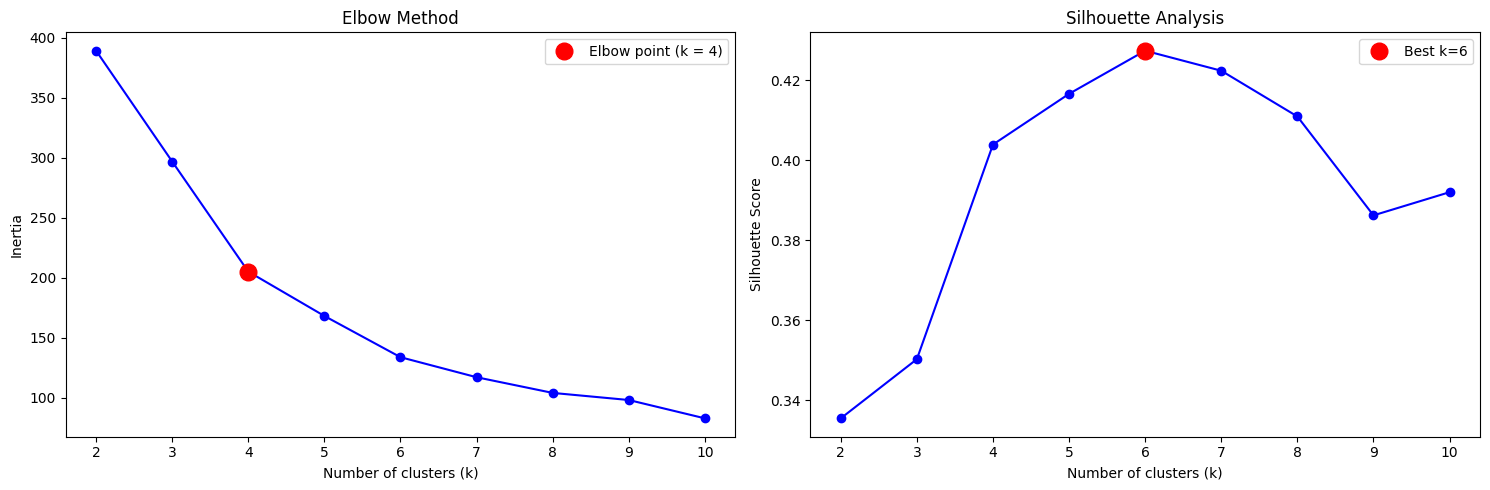

Elbow method suggests k=4
Silhouette analysis suggests k=6

Performing detailed silhouette analysis...


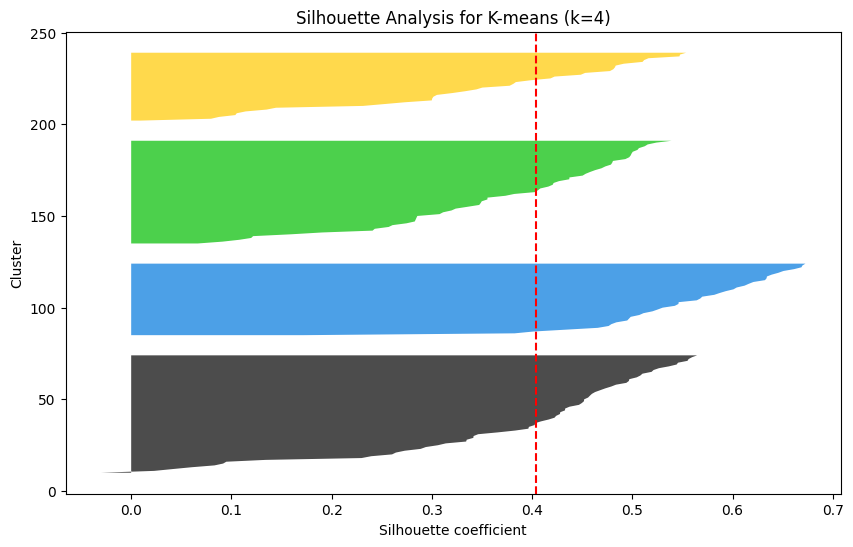

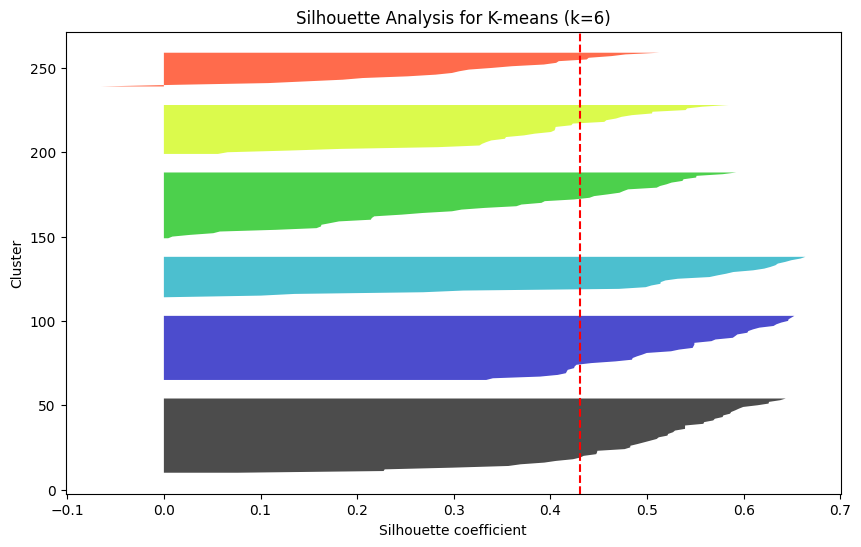


Performing hierarchical clustering analysis...


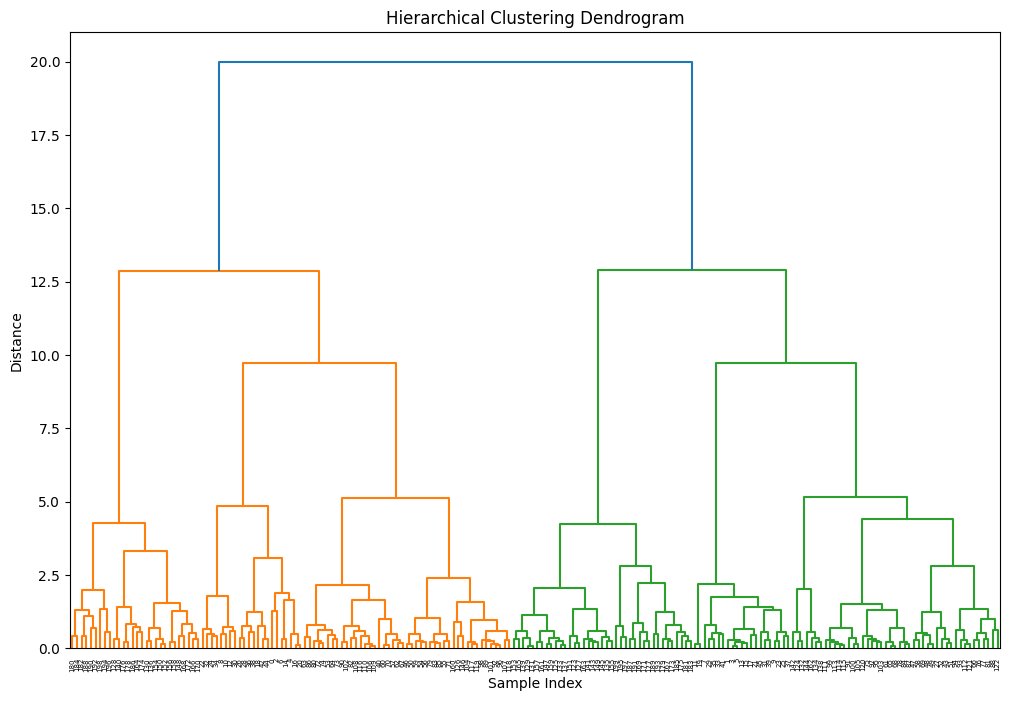


Comparing all clustering methods...


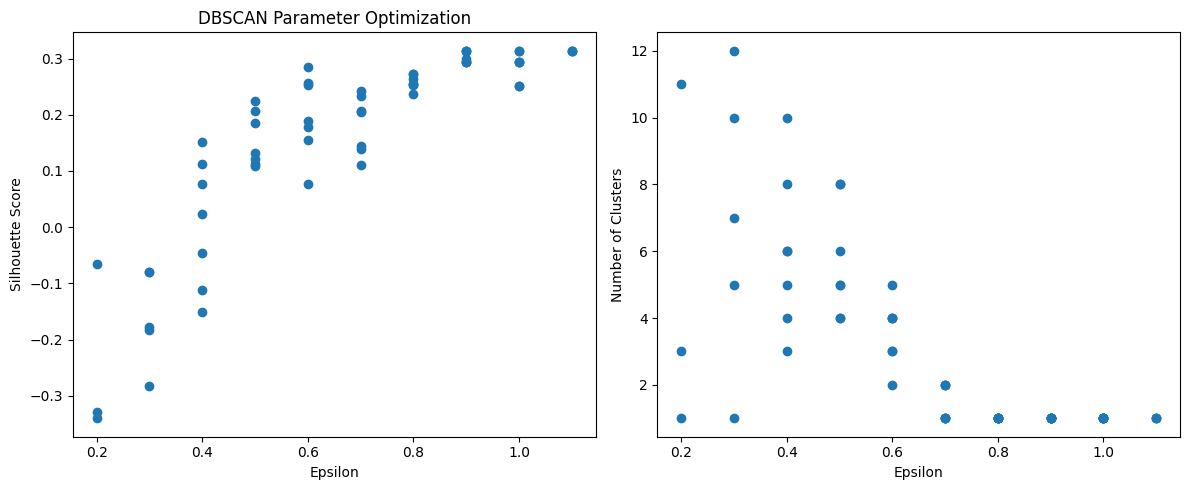


Clustering Results:
K-means: Silhouette Score = 0.404
Hierarchical: Silhouette Score = 0.361
GMM: Silhouette Score = 0.373
DBSCAN: Silhouette Score = 0.314

Best performing method: K-means


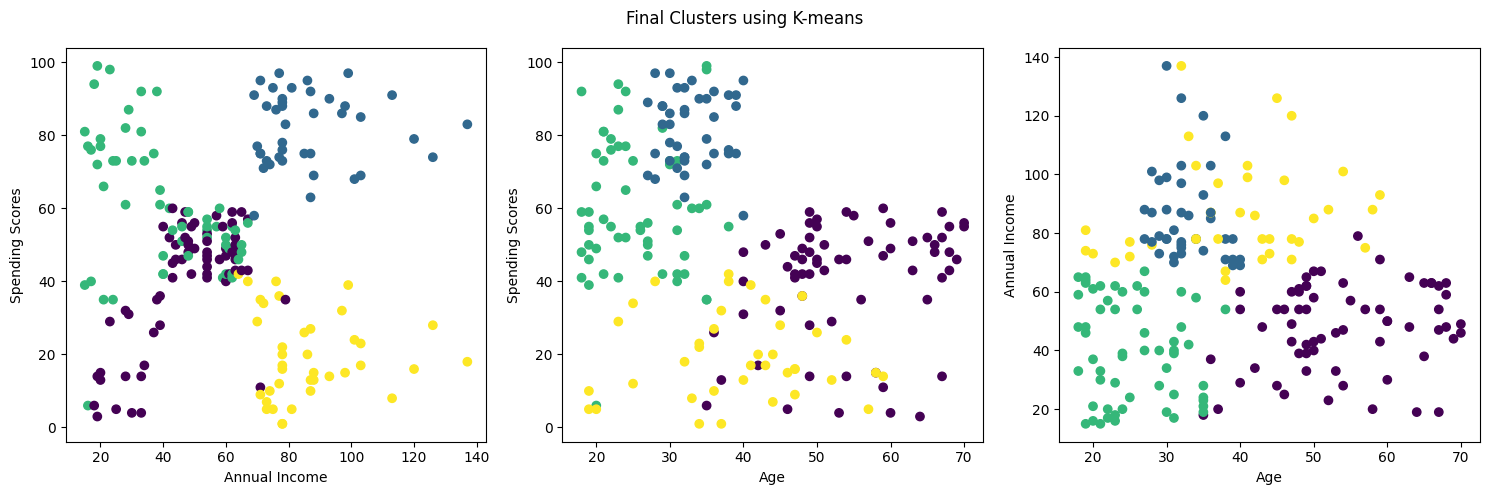

In [39]:
def main():
    
    # Find optimal k
    print("Finding optimal number of clusters...")
    elbow_k, silhouette_k = find_optimal_k(data_scaled)
    print(f"Elbow method suggests k={elbow_k}")
    print(f"Silhouette analysis suggests k={silhouette_k}")
    
    # Detailed silhouette analysis for both k values
    print("\nPerforming detailed silhouette analysis...")
    plot_silhouette_analysis(data_scaled, elbow_k)
    plot_silhouette_analysis(data_scaled, silhouette_k)
    
    # Hierarchical clustering analysis
    print("\nPerforming hierarchical clustering analysis...")
    linkage_matrix = hierarchical_clustering_analysis(data_scaled)
    
    # Compare all methods
    print("\nComparing all clustering methods...")
    k = elbow_k  # Use elbow method k for comparison
    results = compare_clustering_methods(data_scaled, k)
    
    # Print results
    print("\nClustering Results:")
    for method, result in results.items():
        print(f"{method}: Silhouette Score = {result['silhouette']:.3f}")
    
    # Plot final clusters for best method
    best_method = max(results.items(), key=lambda x: x[1]['silhouette'])[0]
    print(f"\nBest performing method: {best_method}")
    
    # Create final visualization
    plt.figure(figsize=(15, 5))
    for i, (x, y) in enumerate([
        ('Annual Income', 'Spending Scores'),
        ('Age', 'Spending Scores'),
        ('Age', 'Annual Income')
    ]):
        plt.subplot(1, 3, i+1)
        plt.scatter(
            data[x], data[y],
            c=results[best_method]['labels'],
            cmap='viridis'
        )
        plt.xlabel(x)
        plt.ylabel(y)
    
    plt.suptitle(f'Final Clusters using {best_method}')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()